# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 - Classification with MLP



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br>N/A<BR>

###  Use only the libraries below:

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
from itertools import chain

from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback, ModelCheckpoint, History 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import seaborn as sns

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score


import tensorflow as tf
import keras.backend.tensorflow_backend as tfb
from keras import backend as K

from sklearn.model_selection import GridSearchCV

%matplotlib inline

<div class="theme"> Overview </div> 

### Galaxy Zoo
For this homework you will work with real astronomical data with the purpose of classifying galaxies based on visual attributes as they appear in astronomical surveys of the night sky, such as color and morphology. Galaxy morphology is strongly correlated with many physical parameters of those astronomical bodies, including their mass, density distribution, temperature, and star formation history. In turn, these parameters can be estimated using observations of the attributes mentioned above. 

The Galaxy Zoo project includes collected morphological attributes of nearly 900,000 galaxies drawn from the [Sloan Digital Sky Survey](http://skyserver.sdss.org/dr15/en/home.aspx). The annotation was provided by hundreds of thousands of volunteers, or 'citizen scientists' as we call them, who voted on the galaxy type based only on its image (for more details on galaxy morphology and classification see <a href="https://academic.oup.com/mnras/article/410/1/166/1032478">Chris Lintott et al.</a>). 

Your task is to train a binary classifier on the Galaxy Zoo data in order to distinguish an elliptical galaxy from spirals, mergers and unknown, which we will call non-elliptical galaxies, based on its visual morphology.  

We provide a subset of data in `galaxy_morphology_labeled.csv` so there is no need for you to download it. The full dataset is available at http://data.galaxyzoo.org.


<span class='sub-q'> Dataset Attributes:</span>
- **green_color**: the amount of light measured in the green frequency band (wavelength range 464 $\pm$ 128~nm)
- **red_color**: the amount of light measured in the red frequency band (wavelength range 658 $\pm$ 138~nm)
- **infrared_color**: the amount of light measured in the infrared frequency band (wavelength range 806 $\pm$ 149~nm)
- **de_vaucouleurs_fit_axial_ratio**: axial ratio associated with the [de Vaucouleurs fit](https://en.wikipedia.org/wiki/De_Vaucouleurs%27_law) to the two-dimensional image of the galaxy
- **exponential_fit_axial_ratio**: the axial ratio associated with an exponential fit to the two-D image of the galaxy 
- **exponential_disc_fit_log_likelihood**: log likelihood associated with an exponential fit to the two-D image of the galaxy
- **de_vaucouleurs_fit_log_likelihood**: log likelihood associated with a de Vaucouleurs fit to the two-D image of the galaxy
- **star_log_likelihood**: the log likelihood that the object is a point-like source (star) object rather than a galaxy
- **number_of_votes**: total number of volunteer votes
- **probability_elliptical**: fraction of votes for elliptical morphology
- **probability_spiral**: fraction of votes for spiral morphology
- **probability_unknown**: fraction of votes for unknown morphology
- **probability_merger**: fraction of votes for merger morphology
- **class**: morphology with the highest fraction of votes

Notice that the volunteers did not have access to any of the attributes but the galaxy shape when voting.

<div class='exercise'><b> Question 1: Models for Galaxy Classification [30pts] </b></div>

<span class='sub-q'> **1.1** Understanding the Problem.</span> It is a good practice to start by familiarizing yourself with the problem in hand. Read the atricle by [Manda Banerji et al.](https://academic.oup.com/mnras/article/406/1/342/1073212) and familiarize yourself with the attributes in the dataset and their descriptions. Based on your reading, which attributes in the data are most predictive of whether or not a galaxy is elliptical?


<div class="alert alert-block alert-info">
Reading the article, we are told that elliptical galazy often appears to be more red. Additionally, we are told that the de Vaucouleurs metric is commonly used one to describe an elliptical galaxy. Thus, the attributes in the data most predictive of whether or not a galaxy is elliptical are the red color of the object (<b>red_color</b>), the axial ratio obtained from a de Vaucouleurs fit to the galaxy image (<b>de_vaucouleurs_fit_axial_ratio</b>), and the log likelihood associated with the de Vaucouleurs fit to the galaxy image (<b>de_vaucouleurs_fit_log_likelihood</b>). This is also confirmed in the historgram plots of these variables showing considerable separation between the eliptical class and the others. 
</div>

In [7]:
# read in and look at data
galaxy_df = pd.read_csv('galaxy_morphology_labeled.csv')
display(galaxy_df.head())
display(galaxy_df.describe())

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,17.952690,17.077210,16.696932,0.652044,0.674899,-299.83917,-147.78073,-2480.1614,30,0.033,0.933,0.033,0.000,spiral
1,15.870294,15.128039,14.746254,0.661844,0.631145,-4980.44200,-2094.24630,-41855.1640,58,0.000,1.000,0.000,0.000,spiral
2,16.473410,15.633129,15.174894,0.324888,0.356353,-3732.98900,-946.47595,-26244.6110,43,0.186,0.744,0.070,0.000,spiral
3,17.137112,16.744455,16.542747,0.582045,0.656639,-33.33683,-587.22380,-4487.7620,63,0.143,0.810,0.048,0.000,spiral
4,17.995703,17.621641,17.377476,0.449918,0.462352,-26.84463,-130.57242,-2392.1540,42,0.167,0.738,0.071,0.024,spiral


,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger
count,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000,20170.000000
mean,17.070687,16.440295,16.130761,0.608844,0.609354,-3868.090280,-2025.123462,-22239.118941,38.765791,0.365983,0.497452,0.093647,0.042877
std,1.165214,1.249285,1.319114,0.228268,0.221225,9036.116288,5628.712115,30610.822090,13.842021,0.303422,0.341853,0.167825,0.116282
min,7.238786,7.619027,7.231207,0.050000,0.050000,-155600.520000,-165467.890000,-244262.300000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,16.550340,15.859993,15.510974,0.435455,0.437437,-3545.562500,-1676.673825,-25458.852750,28.000000,0.091000,0.143000,0.000000,0.000000
50%,17.319927,16.623186,16.270693,0.634461,0.630144,-730.916850,-676.399390,-11928.960000,34.000000,0.291000,0.561000,0.034000,0.000000
75%,17.833663,17.214431,16.903603,0.796282,0.788374,-133.104103,-284.920380,-5387.488300,51.000000,0.611000,0.812000,0.097000,0.032000
max,20.116318,27.952972,28.606903,0.999995,0.999997,0.000000,0.000000,0.000000,86.000000,1.000000,1.000000,1.000000,0.958000


<span class='sub-q'> 1.2 Performing Data Exploration and Cleaning.</span> 



- **1.2.1** The color bands sometimes include values that are far away from the rest, what we call outliers. Outlier values might indicate bad measurements for example instrumental failures. Remove the data points with these values in the color band of your choice. 
- **1.2.2** Are the features sufficiently distinguishing for the classification task? Do elliptical galaxies differ enough in terms of these attributes from other types of objects in the sky? 

**Hint:** compare the distributions of features for elliptical galaxies with the feature distributions of other objects in the data set.

In [8]:
# make the plots of color bands
def plot_bands(band, color, mu, std, k):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    if color == 'infrared':
        ax.scatter(band.index, band.values, color='purple', label=color.capitalize()+' Color Values')
    else:
        ax.scatter(band.index, band.values, color=color, label=color.capitalize()+' Color Values')
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel(band.name, fontsize=14)    
    ax.set_title(color.capitalize()+' Light', fontsize=16)
    ax.set_xticks([])
    ax.axhline(mu, linestyle='--', color='k', label='+/- {} std above/below mean'.format(k))
    ax.axhline(mu+k*std, linestyle='--', linewidth=4, color='k')
    ax.axhline(mu-k*std, linestyle='--', linewidth=4, color='k')
    ax.legend();

In [9]:
# green color
galaxy_grn_mean = np.mean(galaxy_df.green_color.values)
galaxy_grn_std = np.std(galaxy_df.green_color.values)

# red color
galaxy_red_mean = np.mean(galaxy_df.red_color.values)
galaxy_red_std = np.std(galaxy_df.red_color.values)

# infrared color
galaxy_inf_mean = np.mean(galaxy_df.infrared_color.values)
galaxy_inf_std = np.std(galaxy_df.infrared_color.values)

In [10]:
# number of standard deviations over
k_std=3

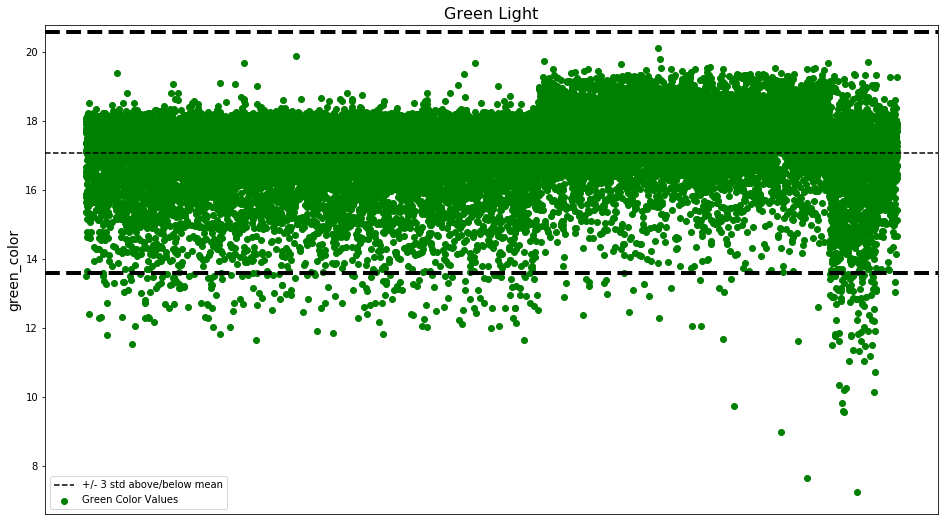

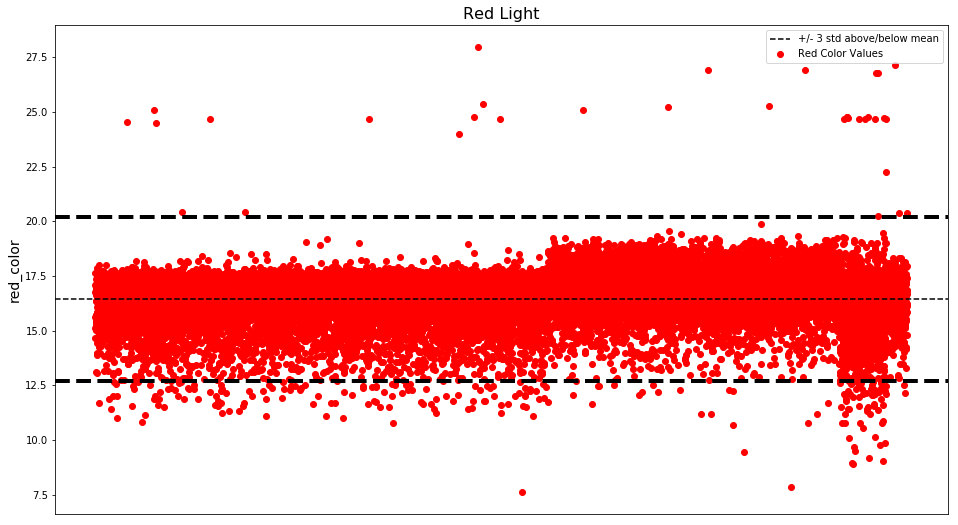

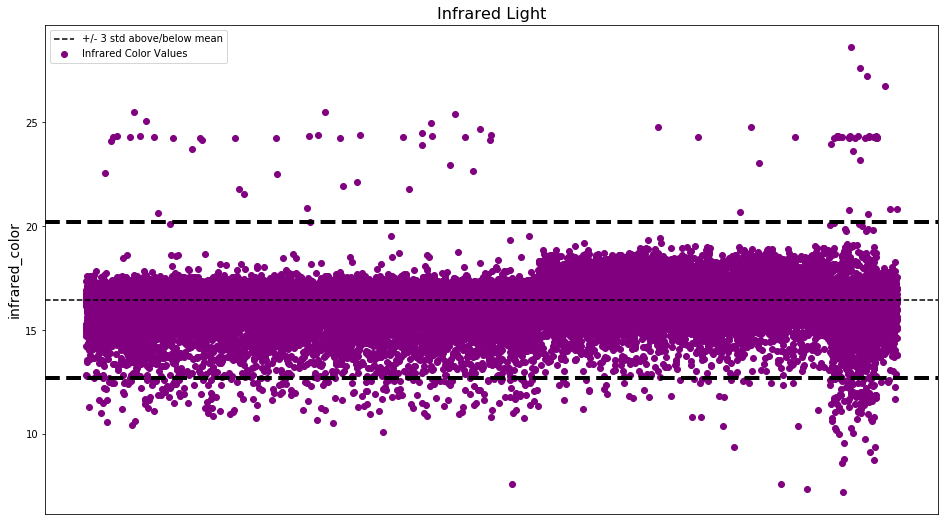

In [11]:
# green color 
plot_bands(galaxy_df['green_color'], 'green', galaxy_grn_mean, galaxy_grn_std, k=k_std)

# red color
plot_bands(galaxy_df['red_color'], 'red', galaxy_red_mean, galaxy_red_std, k=k_std)

# infrared color
plot_bands(galaxy_df['infrared_color'], 'infrared', galaxy_red_mean, galaxy_red_std, k=k_std)


<div class="alert alert-block alert-info">

We define outliers as being three standard deviations above or below the mean. On a nomal distribution, this corresponds to incorporating 99.973% of the distribution. We see from the above plots that there appear to be several several outliers in the red, green, and infrared color bands. 

<br/>
<br/>

Importantly, we see that there is considerable overlap in those obersvations classified as outliers by the three color spectra. As a result, it makes sense to filter by and remove the outlies fromm all three of the color bands.

</div>

In [12]:
# create the masks 
grn_msk = np.absolute(galaxy_df.green_color.values - galaxy_grn_mean) < k_std*galaxy_grn_std
red_msk = np.absolute(galaxy_df.red_color.values - galaxy_red_mean) < k_std*galaxy_red_std
inf_msk = np.absolute(galaxy_df.infrared_color.values - galaxy_inf_mean) < k_std*galaxy_inf_std

In [13]:
# filter 
n_bef_flt = galaxy_df.shape[0]
galaxy_df = galaxy_df[grn_msk&red_msk&inf_msk]
n_after_flt = galaxy_df.shape[0]
diff = n_bef_flt-n_after_flt
print('{} ({:.4f}%) removed data points'.format(diff, diff/galaxy_df.shape[0]*100))

412 (2.0852%) removed data points


In [14]:
# overlap between which observations had outliers removed
overlap = np.zeros((3,3))
msks = [~grn_msk, ~red_msk, ~inf_msk]
msks_labels = ['Green', 'Red', 'Infrared']
for i in range(3):
    for j in range(i,3):
        overlap[i,j] = np.sum(msks[i]&msks[j])
        if i != j:
            overlap[j,i] = overlap[i,j]
overlap = pd.DataFrame(overlap)
overlap.columns = msks_labels
overlap.index = msks_labels
print('Overlap of Observations Removed by Combinations of Masks')
display(overlap)
print('Overlap of all three masks: {}'.format(np.sum(msks[0]&msks[1]&msks[2])))

Overlap of Observations Removed by Combinations of Masks


,Green,Red,Infrared
Green,304.0,218.0,202.0
Red,218.0,263.0,230.0
Infrared,202.0,230.0,300.0


Overlap of all three masks: 195


In [15]:
# make the plot class dists of color bands
def plot_band_dists(band):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    sns.distplot(galaxy_df[band][(galaxy_df['class'] == 'elliptical')], color='blue', label="Elliptical", hist_kws=dict(alpha=.1))
    sns.distplot(galaxy_df[(band)][~(galaxy_df['class'] == 'elliptical')], color='orange', label="Not Elliptical", hist_kws=dict(alpha=.1))
    ax.set_xlabel(band, fontsize=14)
    ax.set_title('Distribution of Galaxy Class over '+band, fontsize=16)
    ax.legend();

In [16]:
# features
print(list(galaxy_df.columns.values[:8]))

['green_color', 'red_color', 'infrared_color', 'de_vaucouleurs_fit_axial_ratio', 'exponential_fit_axial_ratio', 'exponential_disc_fit_log_likelihood', 'de_vaucouleurs_fit_log_likelihood', 'star_log_likelihood']


/usr/share/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


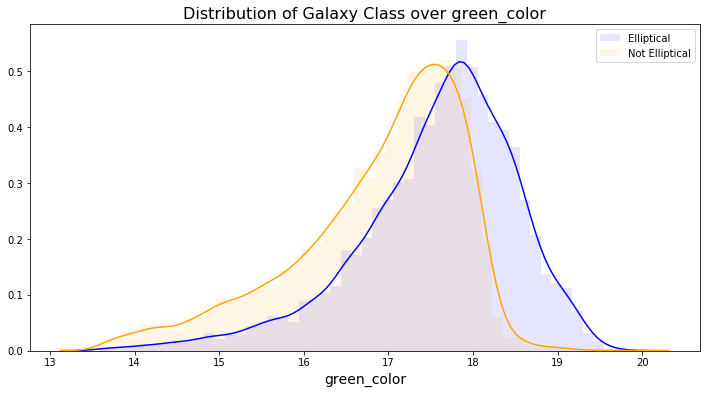

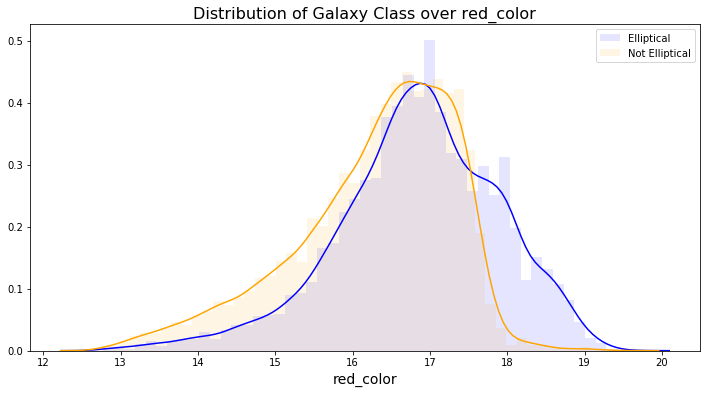

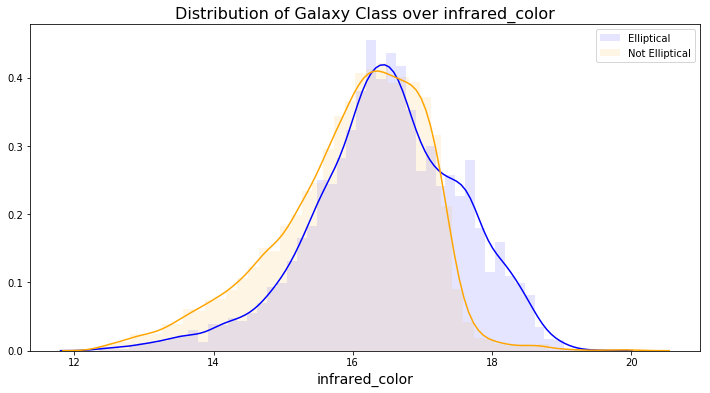

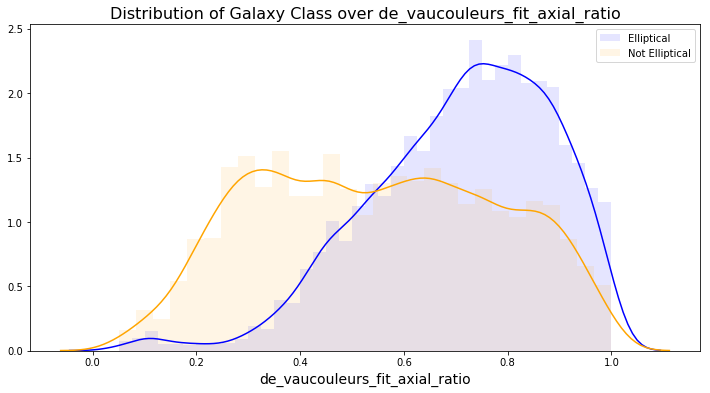

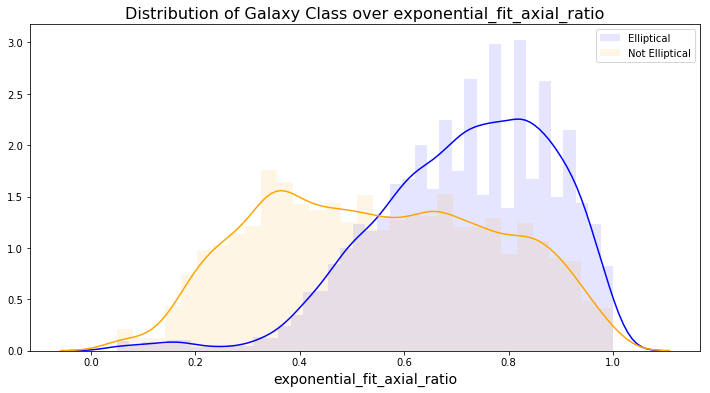

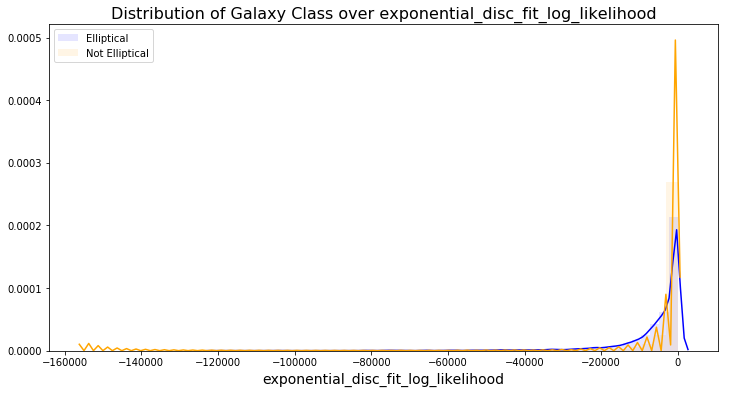

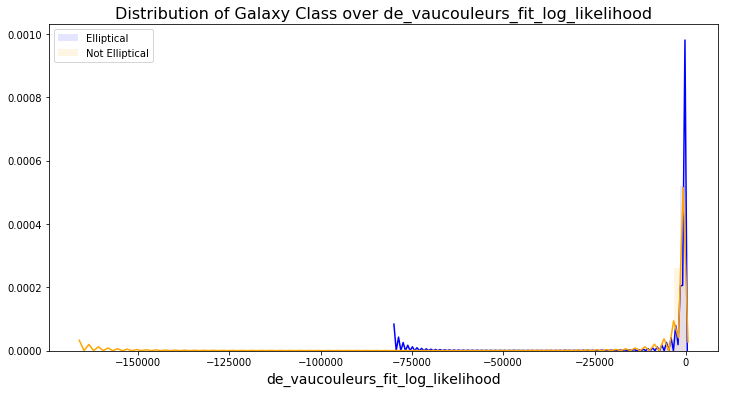

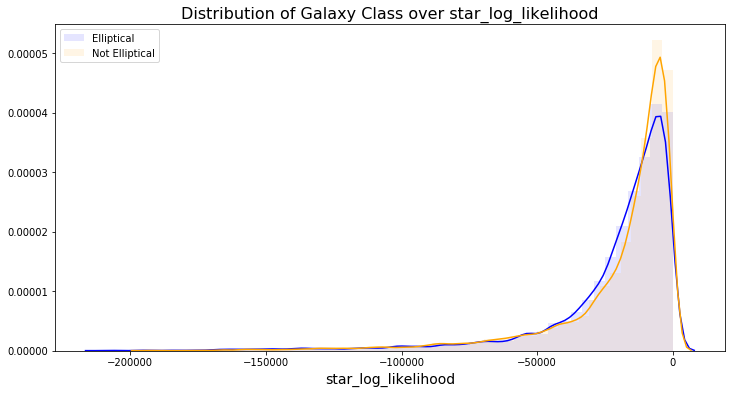

In [13]:
for col in list(galaxy_df.columns.values[:8]):
    plot_band_dists(col)

<div class="alert alert-block alert-info">

From the series of the above distribution plots over the features, we see that the color features - green, red, and infrared - are slightly distinguishing for elliptical galaxies (green in particular). 

<br/>
<br/>

We see more distinguishing distribution plots in the fit axial ratio features, but one of these features - based on the descriptions of these two features - is most likely correlated with the other. 

<br/>
<br/>

Overall, a quick overview may indicate a lack of sufficient features to distinguish the elliptical classes. 

</div>


<span class='sub-q'> 1.3 Feature Engineering. </span> The practice of creating new features by combining observed features in the data using domain knowledge is called *feature engineering*. Astronomers often use differences in color bands as an engineered feature that serves as a proxy to temperature. Create two new features in the data that represent temperature. Do these two new features help distinguish elliptical galaxies from other objects, i.e., are these two new features useful for the classification task?

In [17]:
# differences in color spectra used as a porxy for temperature
# first temperature - temp1 - equals gree - red
# second temperature - temp2 - equals red - infrared
galaxy_df['temp1'] = galaxy_df.green_color - galaxy_df.red_color
galaxy_df['temp2'] = galaxy_df.red_color - galaxy_df.infrared_color

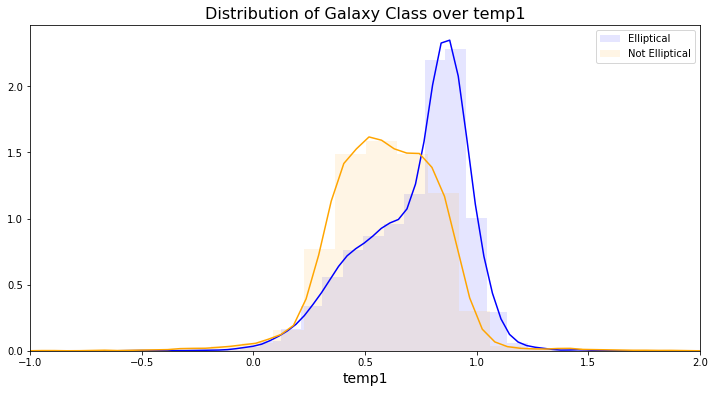

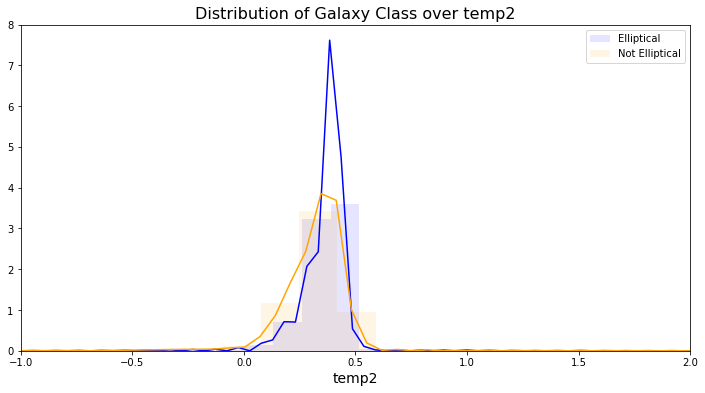

In [15]:
# temp1 and temp2 distributions 
plot_band_dists('temp1')
ax = plt.gca()
ax.set_xlim(-1,2)
plot_band_dists('temp2')
ax = plt.gca()
ax.set_xlim(-1,2);

In [16]:
print('Extremes in temperature 1 (percent of the whole dataset): {:.4f}%'.
      format(np.sum(np.absolute(galaxy_df.temp1) > 1)/galaxy_df.shape[0]*100))
print('')
print('Extremes in temperature 2 (percent of the whole dataset): {:.4f}%'.
      format(np.sum(np.absolute(galaxy_df.temp2) > 1)/galaxy_df.shape[0]*100))


Extremes in temperature 1 (percent of the whole dataset): 3.8061%

Extremes in temperature 2 (percent of the whole dataset): 0.5719%


<div class="alert alert-block alert-info">

We see from the above distribution plots that the additional feature engineered - the difference between the green and red lights - help distinguish elliptical galaxies from non-elliptical ones (with elliptical galaxies having a higher mean for the feature). 
<br/>
<br/>

The second engineered feature - the difference between red and infrared light - is less hopeful as the distributions lay on one another, perhaps offering less power to distinguish elliptical galaxies. 

</div>


<span class='sub-q'> 1.4 Training a Baseline Classifier. </span> Using `keras`, construct and train a MLP classifier to classify galaxies as either elliptical or non-elliptical based on your expanded set of features. 

For the network you want to consider:
- the number of hidden layers
- the number of nodes in each hidden layer
- the activation function (we suggest starting with `relu`)
- the choice of a loss function
- the choice of mini-batch size (we suggest between 1000 and 5000)
- the choice of an optimizer and its parameters, for example: `learning rate`, `momentum`, and `learning rate decay`
- the number of epochs

**Hint:** You can expect to achieve an average classification accuracy of >80% with the appropriate choices.

In [63]:
# create data sets
# grab the 8 features plus featured 2
X_train = galaxy_df.iloc[:, np.r_[0:8, 14:16]].copy()
# end goal in the category:
# 1 (True) = elliptical
# 0 (False) = not elliptical
y_train_ell = galaxy_df['class'] == 'elliptical'
y_train_ell = y_train_ell.values.reshape(-1,1)
y_train_not_ell = ~y_train_ell
y_train = np.concatenate((y_train_not_ell, y_train_ell), axis=1)

In [66]:
# split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.7, random_state=5214)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [34]:
def build_base(n, k, batch, epoch, init, actv_fun, optm, wait=20):
    '''
    n = number of extra hidden layers after the first
    k = constant determining number of nodes in each layer
    batch = batch size
    epoch = number of epochs
    init = initializer
    actv_fun = activation function
    optm = optimizer
    wait = patience for early stopping 
    '''
    # begin model
    ann = Sequential()
    
    # define input layer and first hidden layer
    ann.add(Dense(k*X_train.shape[1], input_shape=(X_train.shape[1],),
                  activation=actv_fun, kernel_initializer=init))
    
    # define next n hidden layers
    for i in range(n):
        # add second hidden layer
        ann.add(Dense(k*X_train.shape[1], activation=actv_fun, kernel_initializer=init))
 
    # add output layer 
    ann.add(Dense(2, activation='sigmoid', kernel_initializer=init))
    
    # callbacks
    # callbacks = [EarlyStopping(monitor='val_loss', patience=wait)]

    # compile it 
    ann.compile(loss='binary_crossentropy', optimizer=optm, metrics=['acc'])
    
    # fit 
    ann.fit(
        X_train, y_train,
        batch_size = batch, epochs=epoch,
        #callbacks=callbacks,
        verbose=False)
    
    return(ann)

In [35]:
def plot_nn(ann, title=''):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(ann.history.history['acc'], color='blue', label='Accuracy')
    ax.plot(ann.history.history['loss'], color='orange', label='Loss')
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend();

<div class="alert alert-block alert-info">

For our base model, we first pulled from the literature and incorporated the architecture of the paper above. We began with two hidden layers (as in the paper), then moved on to 3, 4, 5, 6, and 7 hidden layers in conjuction with different number of nodes for each layer, either at the same size of the input dimensions or twice that number (as in the paper). We tried various kernel initializers, activation functions, and optimizers (with varying learning rates). We see best results when we have four hidden layers with the number of nodes equal to two times the input dimensions using a normal distribution for kernel initialization, the rectified linear acivation function, and Adam as the optimizer. 

<br/>
<br/>

When training the neural nets, we found the above to be the best combination for those hyperparameters. When looking at combinations of batch size and epochs, we found varying combinations which seemed to produce similar results on the training data. Using a smaller batch size and a smaller epoch number produced faster convergence, but convergence towards the end of the epochs got to be quite variable. Using a larger batch size in combination with a larger epoch number produced slower convergence to a similar training score as the latter method, but with slight less variability in the plot towards the end of the epochs. In the end, we chose to consider the batch size at 1024 and epochs at 2000. When evaluating this model on the test set, we achieve 90% accuracy - although this is variable.

</div>


5928/5928 [==============================] - 0s 18us/step


[0.28105115964405447, 0.8947368421052632]

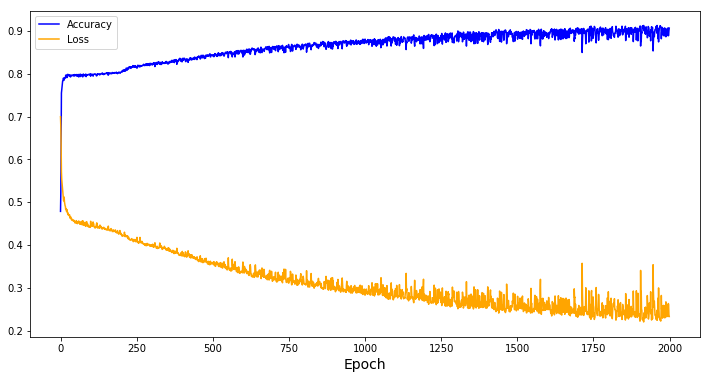

In [23]:
# build base model; train for 2000 epochs at batch size 1024
ann_base = build_base(n=3,k=2,batch=1024,epoch=2000,init='normal',actv_fun='relu',optm='adam')
plot_nn(ann_base)
ann_base.evaluate(X_test, y_test)

<div class="alert alert-block alert-info">

After carrying out the above, we realize that we did not standardize our data, and the issues identified before standardization our ammended. We cross-validate and obtain similar hyperparameter results. In evaluating this new model, we see improved accuracy to 92% - although this is variable. 

</div>


In [36]:
# scale 
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

5928/5928 [==============================] - 0s 18us/step


[0.24282729513591278, 0.9178475033738192]

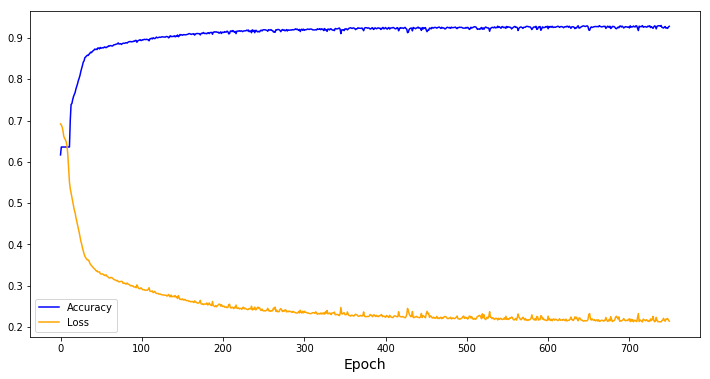

In [37]:
# build base model; train for 750 epochs at batch size 1024
ann_base_norm = build_base(n=3,k=2,batch=1024,epoch=750,init='normal',actv_fun='relu',optm='adam')
plot_nn(ann_base_norm)
ann_base_norm.evaluate(X_test, y_test)

5928/5928 [==============================] - 0s 22us/step


[0.23226829222309203, 0.9169197031039136]

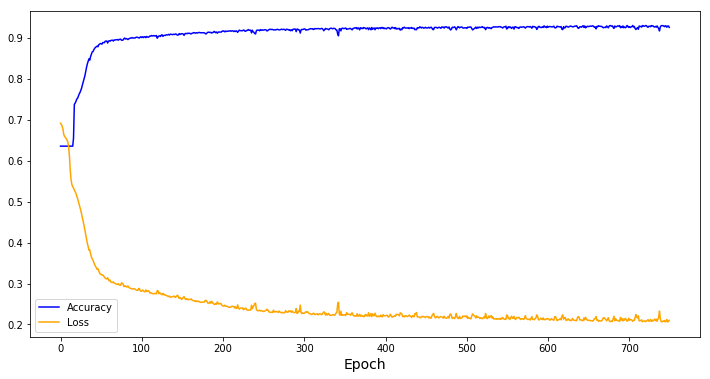

In [25]:
# build base model; train for 750 epochs at batch size 1024
ann_base_norm = build_base(n=3,k=2,batch=1024,epoch=750,init='normal',actv_fun='relu',optm='adam')
plot_nn(ann_base_norm)
ann_base_norm.evaluate(X_test, y_test)

<span class='sub-q'>1.5 Evaluating and Improving Your Classifier. </span> Choose an appropriate metric for evaluating your classifier. Is the average classification accuracy a good metric for this data given the distribution of the classes? Improve your classifier based on the distribution of the classes and on your evaluation of the baseline classifier. 

**Hint:** You can expect to achieve an average classification accuracy of >90% with this.

In [27]:
print('Percentage of elliptical galaxies in training data: {:4f}%'.
     format(np.sum(y_train[:,1])/y_train.shape[0]*100))
print('Percentage of non-elliptical galaxies in training data: {:4f}%'.
     format(np.sum(y_train[:,0])/y_train.shape[0]*100))

Percentage of elliptical galaxies in training data: 36.391902%
Percentage of non-elliptical galaxies in training data: 63.608098%


In [28]:
print('Percentage of elliptical galaxies in test data: {:4f}%'.
     format(np.sum(y_test[:,1])/y_test.shape[0]*100))
print('Percentage of non-elliptical galaxies in test data: {:4f}%'.
     format(np.sum(y_test[:,0])/y_test.shape[0]*100))

Percentage of elliptical galaxies in test data: 36.774629%
Percentage of non-elliptical galaxies in test data: 63.225371%


<div class="alert alert-block alert-info">

We can see from the above that we can achieve 63% accuracy by simply classifying all points as non-elliptical. In the most extreme case, where one class is 99.9% of the data, we can reach 99.9% accuracy by simply predicting the majority class. This is a result of inbalanced datasets.

 <br/>
 <br/>

Let's look at a different measure of accuracy that takes into account the precision and recall measures through their harmonic mean. The is the F1 score, which provides a measure of a classification procedure's usefullness. 

 <br/>
 <br/>
 
Additionally, let's look to use a different measure of loss that takes into account the inbalanced distribution of classes in the data: the weighted binary cross entropy. Incorporating this, and cross validating to determine the other hyperparameters, we achieve a (repeated) accuracy around 93%, a slight improvement over the previous 92%. However, we curiously notice a drop in the F1 score, which is slightly concerning. Ultimately, the different in proprotions of the classes is perhaps not that extreme that we should consider having to correct for it. 

 <br/>
 <br/>


Optimization code below.

</div>

```python
# model search for 1.5
model_CV = KerasClassifier(build_fn=build_new, verbose=0)

# define the grid search parameters
n_vals = [1,2,3,4,5,6,7]
k_vals = [1,2,3]
batch_vals = [512,1024,2048]
epoch_vals = [150,300,750,1200,1500]
inits = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
actv_funcs = ['relu', 'elu', 'leakyrelu']
optms = ['adam','nadam', SGD(momentum=0.8), 'rmsprop', 'adagrad']

param_grid = dict(n=n_vals, k=k_vals, batch=batch_vals, epoch=epoch_vals, init=inits, actv_fun=actv_funcs,optm=optms)

grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=None, cv=4)
grid_result = grid.fit(X_train, y_train)
```


<div class="alert alert-block alert-info">

Add new accuracy function.

</div>


In [20]:
# adapted from https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
# adds f1 score to Keras
def f1(y_true, y_pred):
    if len(y_pred.shape) > 1:
        y_true = y_true[:,1]
        y_pred = y_pred[:,1]
    def recall(y_true, y_pred):
        """Recall metric.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return (2*((precision*recall)/(precision+recall+K.epsilon())))

<div class="alert alert-block alert-info">

Add new cost function - weighted binary cross entropy - through tensorflow backend. 

</div>




In [21]:
# define new loss to keras from tf
# the weighted binary cross entropy loss
# multiplier for positive targets
POS_WEIGHT = np.reciprocal(np.sum(y_train[:,1] == 1)/np.sum(y_train[:,1] == 0))  
def weighted_binary_crossentropy(target, output):
    # transform back to logits
    epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, epsilon, 1 - epsilon)
    output = tf.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(targets=target, logits=output,pos_weight=POS_WEIGHT)
    return(tf.reduce_mean(loss, axis=-1))

<div class="alert alert-block alert-info">

Build model.

</div>



In [22]:
# build the new model
def build_new(n, k, batch, epoch, init, actv_fun, optm, wait=50):
    '''
    n = number of extra hidden layers after the first
    k = constant determining number of nodes in each layer
    batch = batch size
    epoch = number of epochs
    init = initializer
    actv_fun = activation function
    optm = optimizer
    wait = patience for early stopping 
    '''
    # begin model
    ann = Sequential()
    
    # define input layer and first hidden layer
    ann.add(Dense(k*X_train.shape[1], input_shape=(X_train.shape[1],),
                  activation=actv_fun, kernel_initializer=init))
    
    # define next n hidden layers
    for i in range(n):
        # add second hidden layer
        ann.add(Dense(k*X_train.shape[1], activation=actv_fun, kernel_initializer=init))
 
    # add output layer 
    ann.add(Dense(2, activation='sigmoid', kernel_initializer=init))

    # compile it 
    ann.compile(loss=weighted_binary_crossentropy, optimizer=optm, metrics=['acc', f1])
    
    # fit 
    ann.fit(
        X_train, y_train,
        batch_size = batch, epochs=epoch,
        validation_data = (X_test, y_test),
        verbose=False)
    
    return(ann)

5928/5928 [==============================] - 0s 29us/step


[0.28084002092339894, 0.9245951417004049, 0.889640280753173]

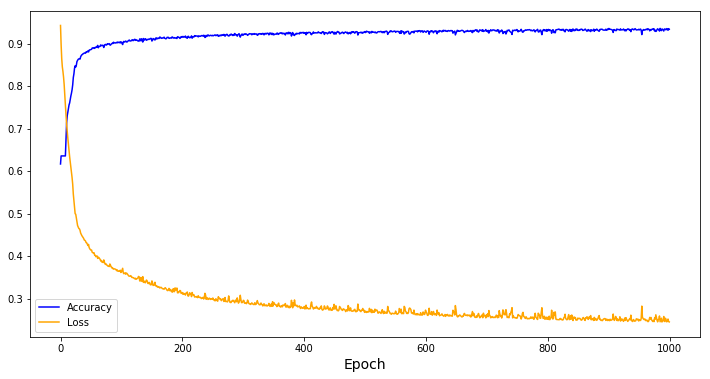

In [37]:
# new model
ann_new = build_new(n=3,k=2,batch=1024,epoch=1000,init='glorot_uniform',actv_fun='relu',optm='adam')
plot_nn(ann_new)
ann_new.evaluate(X_test, y_test)

In [52]:
# dummy prediction
y_pred_dummy = np.zeros(y_test.shape[0])

# prediction from the previous model in 1.4
y_pred_base_norm = ann_base_norm.predict(X_test)
y_pred_base_norm_class = y_pred_base_norm.argmax(axis=-1) == 1

# prediction from model in 1.5
y_pred_new = ann_new.predict(X_test)
y_pred_new_class = y_pred_new.argmax(axis=-1) == 1

In [53]:
# accuracy scores
dummy_acc = accuracy_score(y_test[:,1], y_pred_dummy)
base_norm_acc = accuracy_score(y_test[:,1], y_pred_base_norm_class)
new_acc = accuracy_score(y_test[:,1], y_pred_new_class)
print("Accuracy scores")
print('-'*30)
print('Dummy model: {:.4f}%'.format(dummy_acc))
print('1.4 NN model: {:.4f}%'.format(base_norm_acc))
print('1.5 NN model: {:.4f}%'.format(new_acc))

Accuracy scores
------------------------------
Dummy model: 0.6323%
1.4 NN model: 0.9168%
1.5 NN model: 0.9180%


In [44]:
# f1 scores
dummy_f1 = f1_score(y_test[:,1], y_pred_dummy, average='micro')
base_norm_f1 = f1_score(y_test[:,1], y_pred_base_norm_class)
new_f1 = f1_score(y_test[:,1], y_pred_new_class)
print("F1 scores")
print('-'*30)
print('Dummy model: {:.4f}%'.format(dummy_acc))
print('1.4 NN model: {:.4f}%'.format(base_norm_acc))
print('1.5 NN model: {:.4f}%'.format(new_f1))

F1 scores
------------------------------
Dummy model: 0.6323%
1.4 NN model: 0.9168%
1.5 NN model: 0.8793%


<div class='exercise'><b> Question 2: Optimization Problems in Model Training </b></div>

In Question 1, you found an appropriate choice of training parameters for your model (e.g. optimizer, learning rate etc). In this problem, you will carefully investigate the effect of these parameters on the baseline model from Question 1.

<span class='sub-q'> 2.1 </span> Using the Adam optimizer, plot the loss function as well as the average classification accuracy [PP: training accuracies] for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set.

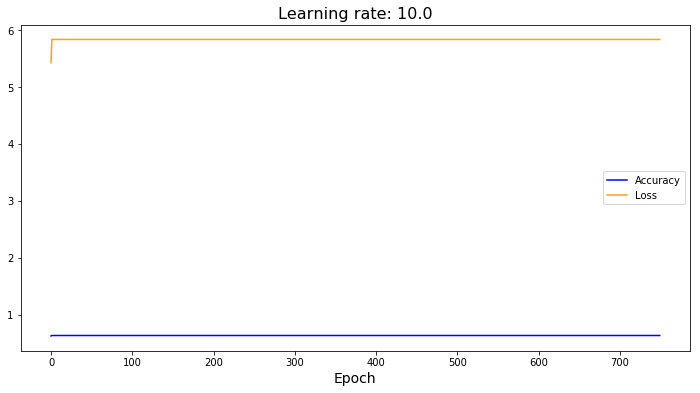

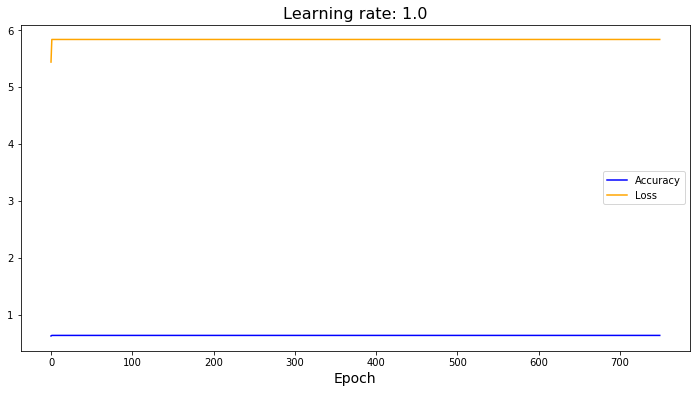

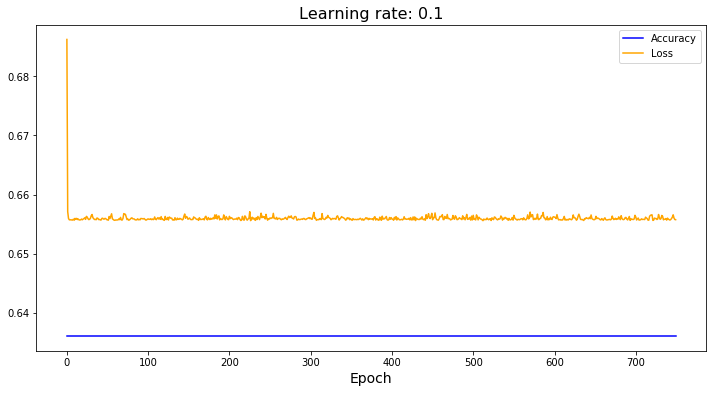

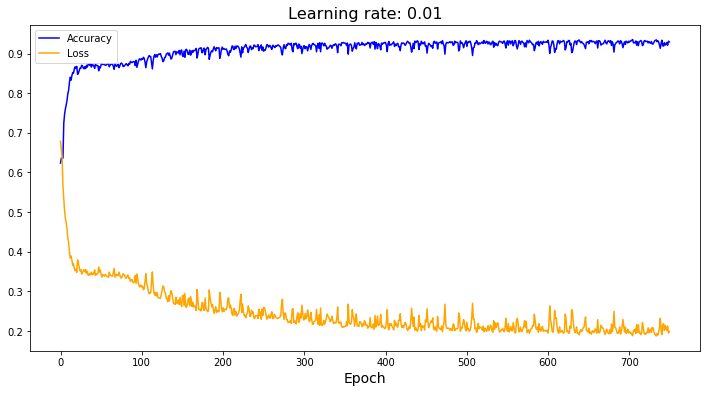

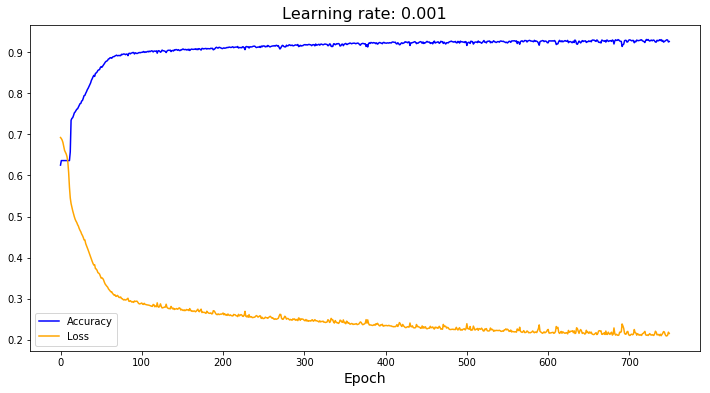

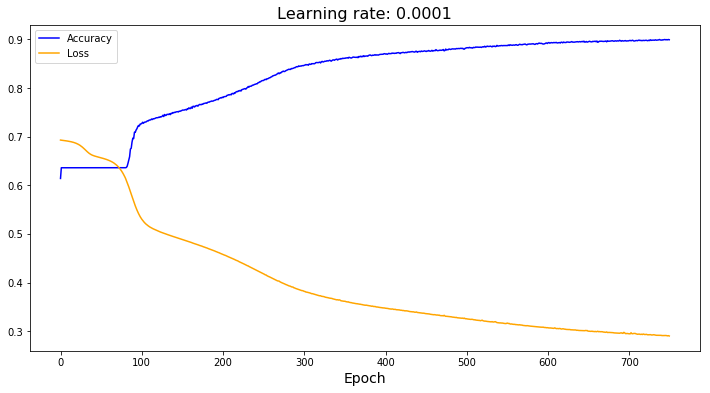

In [33]:
# ADAM
lrn_rates = [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]
for lrn in lrn_rates:
    model = build_base(n=3,k=2,batch=1024,epoch=750,init='normal',actv_fun='relu',optm=Adam(lr=lrn))
    plot_nn(model, 'Learning rate: '+str(lrn))

<div class="alert alert-block alert-info">

From the above plots, we see that the learning rate of 0.001 (the default rate) is by far the best suited for the data and model at hand. The plot fo the 0.001 rate shows a smooth fall - no drastic jumps - in the training loss - in addition to the training accuracy - and achieves continuous improvement. 

</div>


<span class='sub-q'> 2.2 </span> Using the SGD optimizer, plot the loss function as well as the average classification accuracy for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set. For the optimal learning rate, experiment with a range of values for momentum, `[9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1]` with a learning rate decay of `optimal_rate / total_epochs`. Make an argument for which value of momentum is more appropriate for our data set.

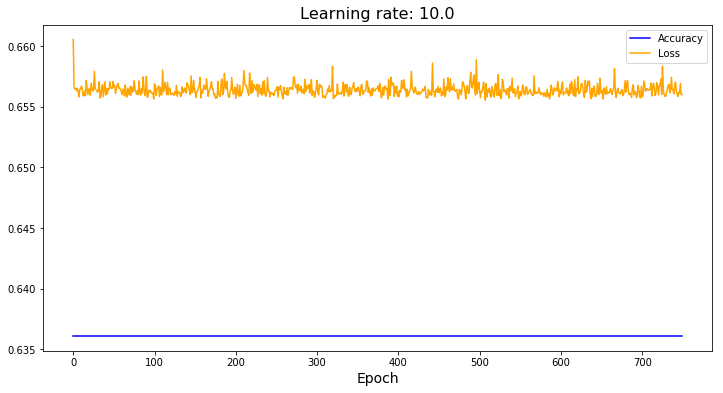

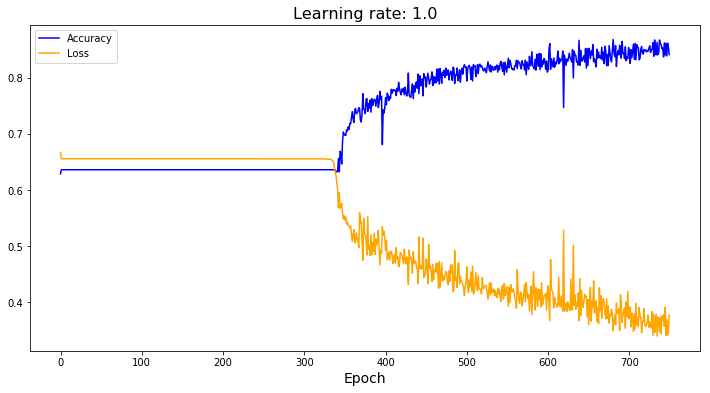

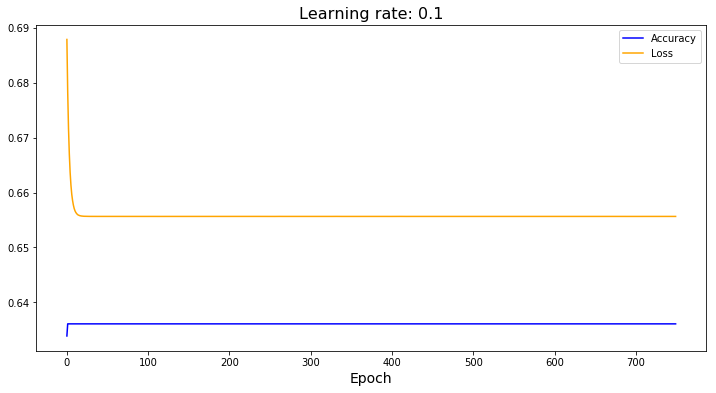

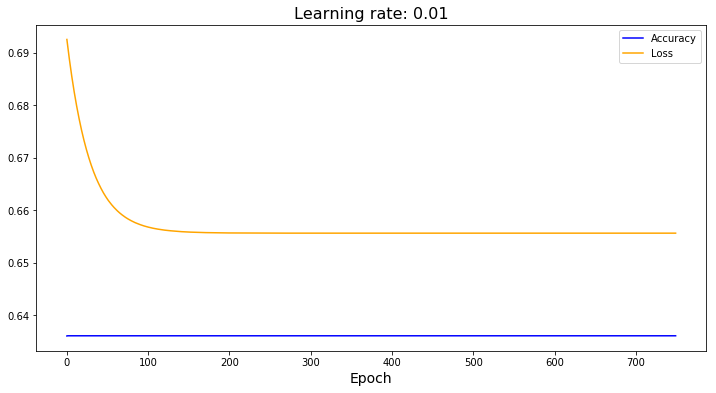

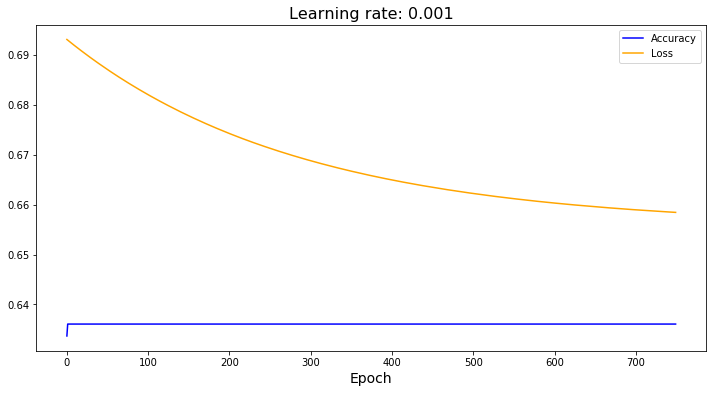

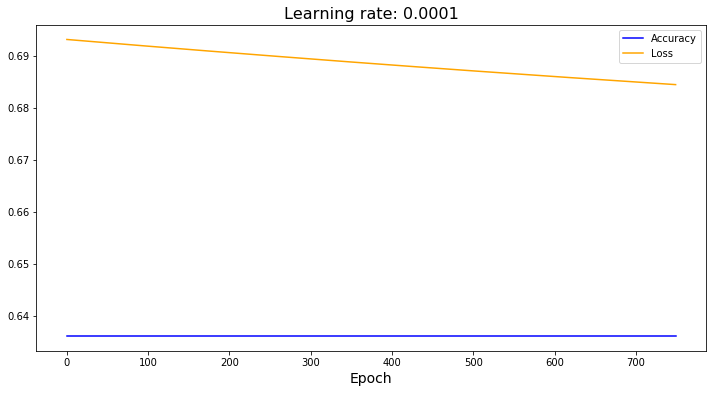

In [129]:
# SGD
lrn_rates = [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]
for lrn in lrn_rates:
    model = build_base(n=3,k=2,batch=1024,epoch=750,init='normal',actv_fun='relu',optm=SGD(lr=lrn))
    plot_nn(model, 'Learning rate: '+str(lrn))

<div class="alert alert-block alert-info">

From the above plots, it is difficult to determine an optimal learning rate as SGD seems to be stuck in local minimum that it cannot get out from - which makes sense as the architecture we fit was ultimately optimized for the Adam optimizer. That being said, it appears like a learning rate of 1 looks to be the best so far from the above plots. 

</div>


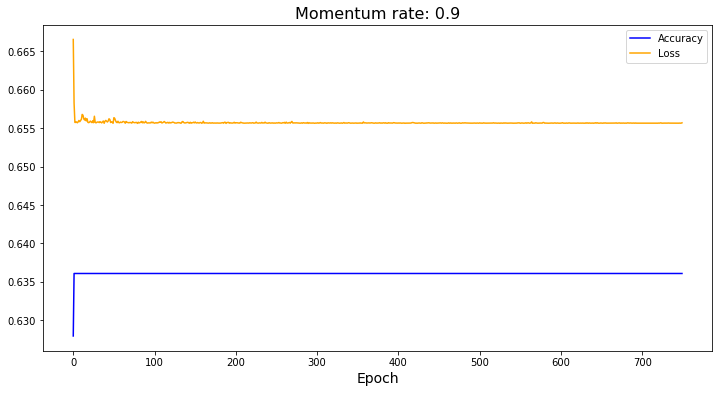

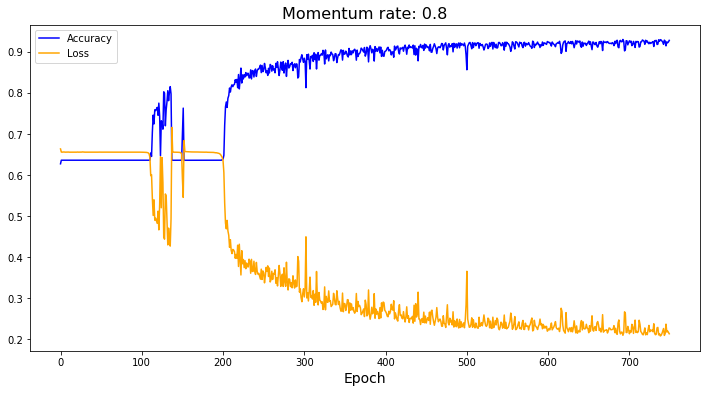

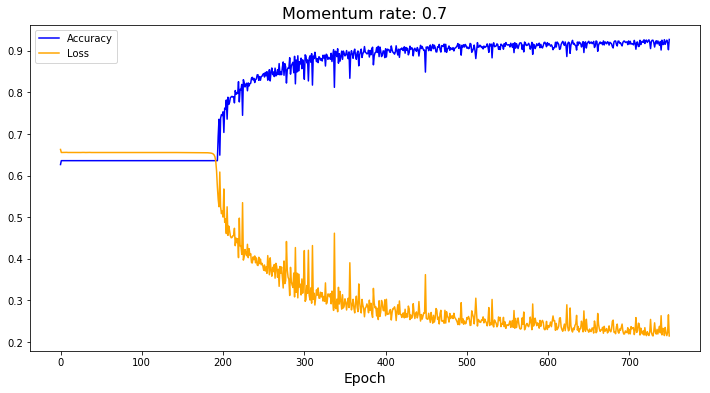

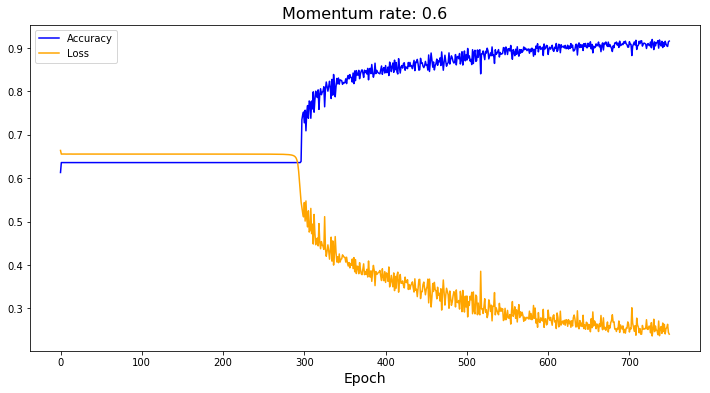

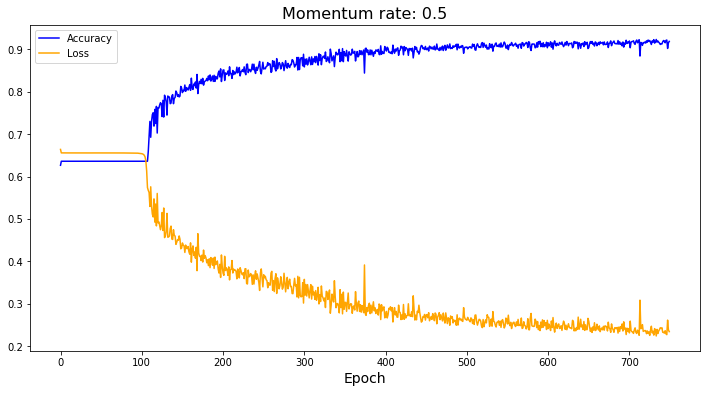

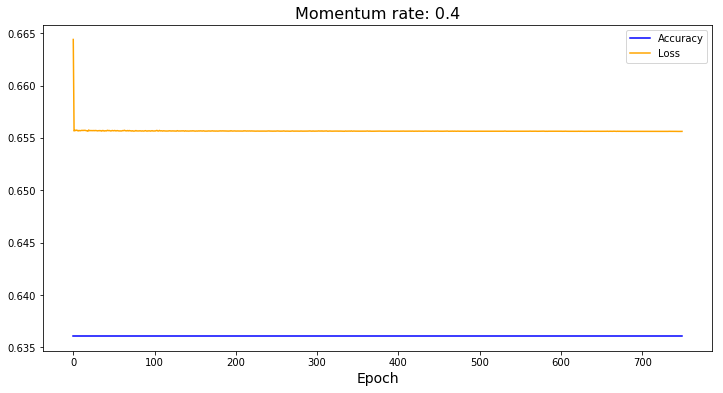

In [134]:
momentum = [9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1]
lrn=1
epoch = 750
decay=lrn/epoch
for m in momentum:
    model = build_base(n=3,k=2,batch=1024,epoch=epoch,init='normal',actv_fun='relu',optm=SGD(lr=lrn, decay=decay, momentum=m))
    plot_nn(model, 'Momentum rate: '+str(m))

<div class="alert alert-block alert-info">

From the above plots, we see that a momentum value at 0.5 seems to produce the best results i.e. getting out of that local minimum that each model struggles to get out of, doing so earlier than the other momentum values and not falling back. 

</div>


<span class='sub-q'> 2.3 </span> Compare model training using Adam versus SGD:
- describe the difference between the behaviors of these two optimizers. 
- which optimizer gives the best model at the end of say 5000 epochs?

Which optimization method do you prefer for this data set? Why? 
Think of some scenarios where each optimizer might be more appropriate than the other.

Other parameters for optimization include more complex decay rates, you can [read more](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2) about how these choices affect training.

<div class="alert alert-block alert-info">

In general, we see (and it has been observed) that Adam tends to converge faster than SGD. Adam is able to achieve this as it maintains individual adaptive learning rates for the parameters based on the first and second moments of the gradients, which SGD does not. We can incoporate adaptive learning to SGD through learning rate schedulers over the epochs and with momentum, but this still does not compare to the work Adam does. Thus, we can say that Adam is doing a lot more to learn from the data and be precise to it with each paramter. As a result, Adam tends to achieve better convergence performance. However, it has been offered that adaptive methods generalize worse than SGD, even when these solutions have better training performance. This may be a result of the autotuning which is done in Adam versus the customized tuning done with choosing adaptive schedulers and momentum in SGD. This of course has not been settled.


<br/>
<br/> 

Ultimately, we see better performance and convergence with the Adam optimizer. The SGD tends to get stuck get stuck in the local minima. In essence, we might want to use Adam when we would want to reach convergence faster and when we are unavailable to perform the super fine-tuning needed for SGD - many cross validation procedures to determine the hyperparameters and many epochs to get out of local minima. 

</div>


5928/5928 [==============================] - 4s 612us/step


[0.19041754517015497, 0.9310053981106613]

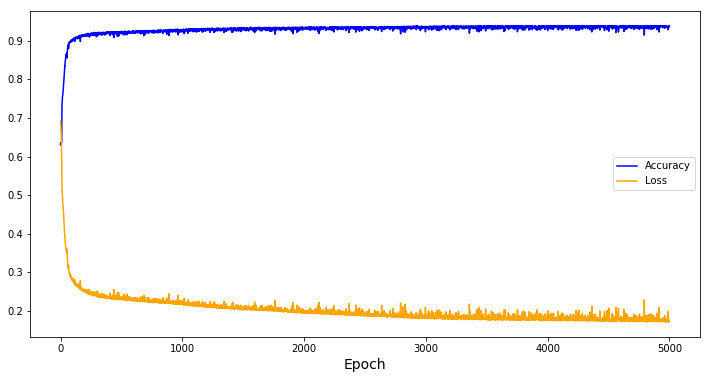

In [46]:
# adam optimizer at 5000
adam_5000 = build_base(n=3,k=2, batch=1024,epoch=5000,init='normal',actv_fun='relu',optm='adam')
plot_nn(adam_5000)
adam_5000.evaluate(X_test, y_test)

<div class="alert alert-block alert-info">

Refitting the below SGD model is not like refitting the above Adam model: SGD is considerly variable as to where its performance will land, even after 5000 epochs, whereas Adam always convergences fairly quickly. 

</div>


5928/5928 [==============================] - 2s 407us/step


[0.6577494995474976, 0.6322537112010796]

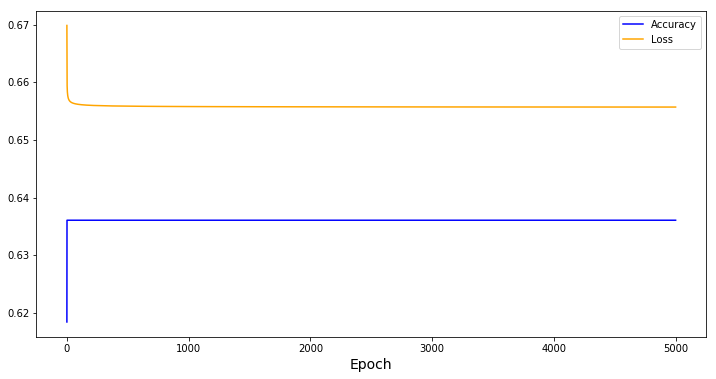

In [173]:
# SGD optimizer at 5000
lrn=1
decay=lrn/5000
sgd_5000 = build_base(n=3,k=2, batch=1024,epoch=5000,init='normal',actv_fun='relu',optm=SGD(lr=lrn, decay=decay, momentum=0.5))
plot_nn(sgd_5000)
sgd_5000.evaluate(X_test, y_test)

<div class='exercise'><b> Question 3: Generalizing Models for Galaxy Classification </b></div>

In this problem, you will revisit the task of classifying galaxies based on visual morphology. You will deploy the model you built in Question 1 on a new, much larger sky survey. In this new data set, which for now we will assume it represents the true Universe, only a small number of observations have been labeled. Your goal is to estimate the proportion of elliptical galaxies in the Universe.
<br><br>**Note** There are multiple *correct* answers to these questions. What we are looking for is a scientific approach to support your arguments with empirical evidences or first principles. 

<span class='sub-q'> 3.1 </span> Use the model you built in Question 1 to estimate the proportion of ellipticall galaxies. Is this estimate trust worthy? Why or why not? 



<div class="alert alert-block alert-info">

A lot of the data in the "unverse" set is unlabeled. To evaluate our data, we will perform the feature engineering we carried out in the previous dataset, scale using the scaler from the previous data set, and predict. 

</div>


In [42]:
universe_df = pd.read_csv('galaxy_morphology_semi_labeled.csv')
display(universe_df.head())

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,20.597660,19.763248,19.377018,0.890790,0.887719,-365.51312,-10296.39500,-69448.500,NaN,NaN,NaN,NaN,NaN,NaN
1,16.068602,14.275770,13.406208,0.846962,0.583541,-12756.09600,-32272.31200,-203823.920,NaN,NaN,NaN,NaN,NaN,NaN
2,25.601834,23.291614,24.511544,0.699872,0.749809,-86.31708,-227.30617,-1036.990,NaN,NaN,NaN,NaN,NaN,NaN
3,22.686954,20.837614,20.032396,0.705292,0.655978,-8858.64400,-1597.61410,-38869.620,NaN,NaN,NaN,NaN,NaN,NaN
4,20.464190,19.271786,18.617180,0.470536,0.424177,-1635.48885,-11248.65150,-83958.805,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# differences in color spectra used as a porxy for temperature
# first temperature - temp1 - equals gree - red
# second temperature - temp2 - equals red - infrared
universe_df['temp1'] = universe_df.green_color - universe_df.red_color
universe_df['temp2'] = universe_df.red_color - universe_df.infrared_color

In [45]:
# copy
X = universe_df.iloc[:, np.r_[0:8, 14:16]].copy()
y = universe_df['class'].copy()
# filter 
X = X[pd.notna(y)]
y = y[pd.notna(y)]
# transform
X = scaler.transform(X)
y_ell = y == 'elliptical'
y_ell = y_ell.values.reshape(-1,1)
y_not_ell = ~y_ell
y = np.concatenate((y_not_ell, y_ell), axis=1)

In [120]:
# evaluate
adam_5000.evaluate(X,y)

4702/4702 [==============================] - 0s 32us/step


[5.555901192138165, 0.4727775415097435]

In [137]:
print('Percent of ellipticals in the filtered data: {:.4f}'.format(100*np.sum(y_ell)/y_ell.shape[0]))

Percent of ellipticals in the filtered data: 46.3420


<div class="alert alert-block alert-info">

We see that the model performs poorly on this dataset, with an accuracy below what we could have predicted using the majority class. Thus, to use our model to predict the proportion of elliptical galaxies in the universe dataset is not trust worthy.

</div>


<span class='sub-q'> 3.2 </span> The performance of classifier will perform differently on this new data set than it does on the data the model was trained (and tested on) in question 1. This is a common occurance in machine learning. Identify and eliminate at least one likely cause of this performance difference in the data. 

(***Hint:*** perform some exploratory data analysis on the new data and compare the features distributions of the data set in question 1 and of the data in this question)

<div class="alert alert-block alert-info">

Let's take a look at the distribution of the features used in the orginal model across the datasets.

</div>


In [39]:
feats = list(galaxy_df.columns[:8]) + list(galaxy_df.columns[-2:])

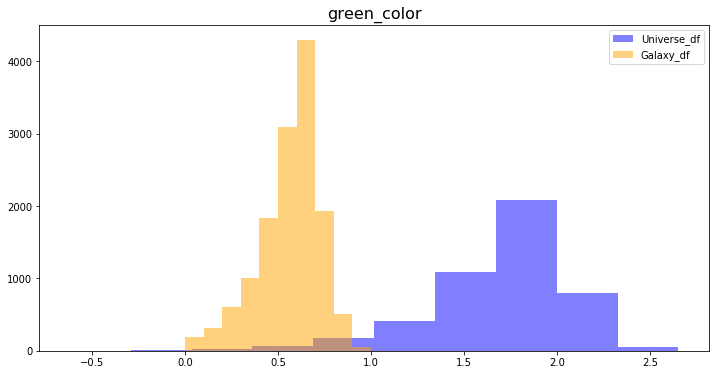

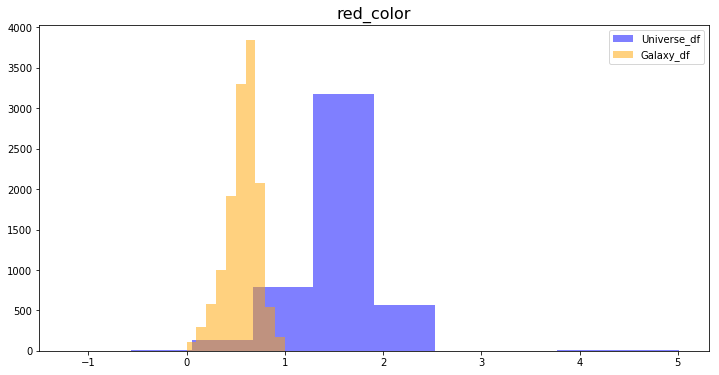

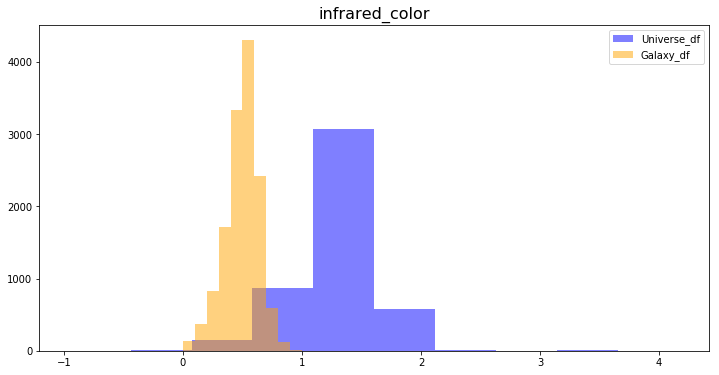

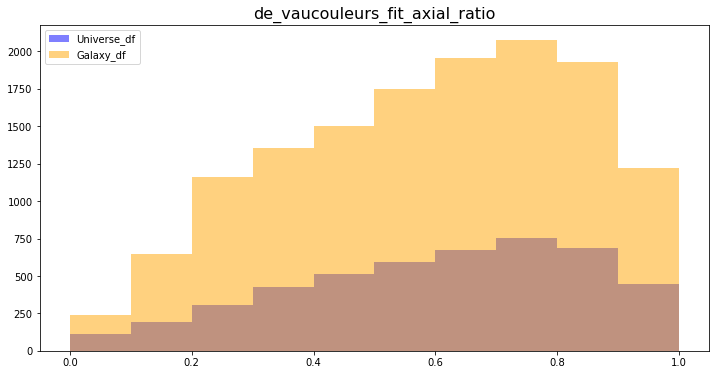

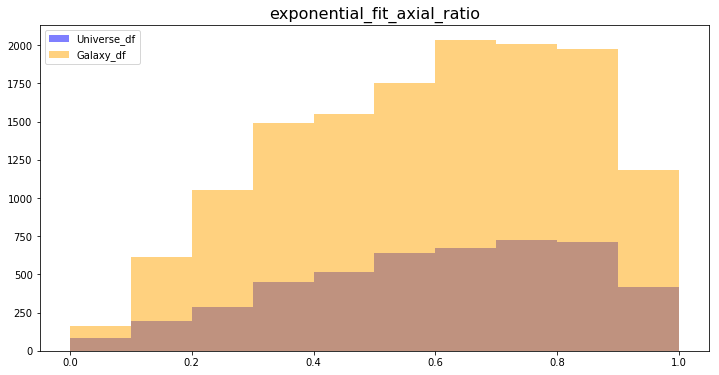

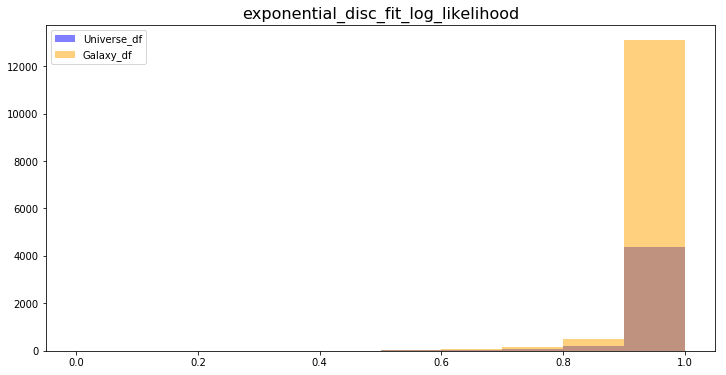

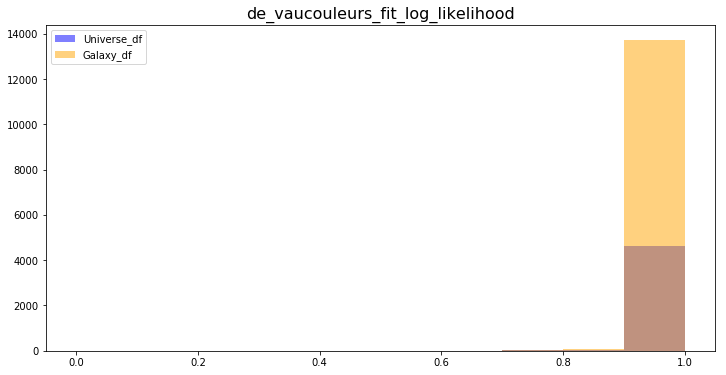

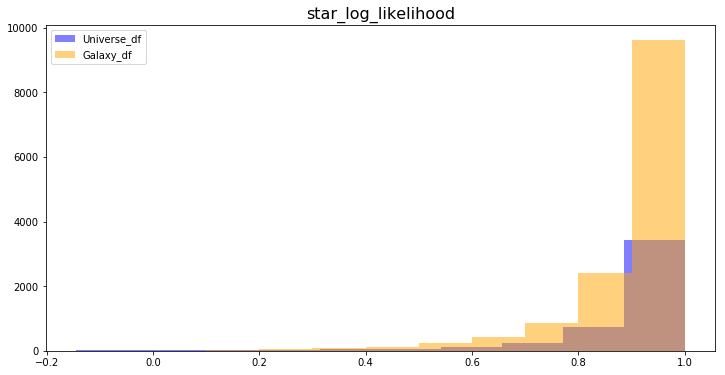

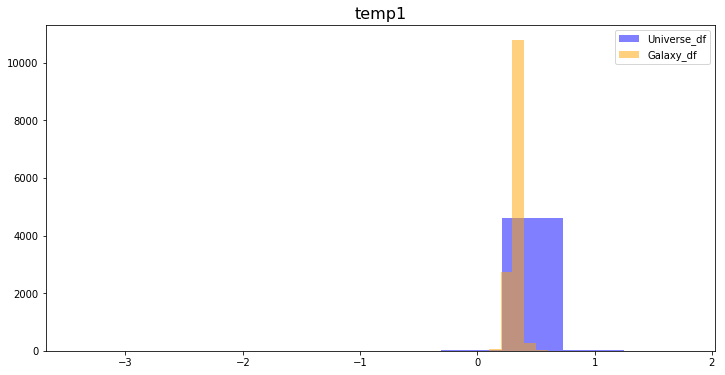

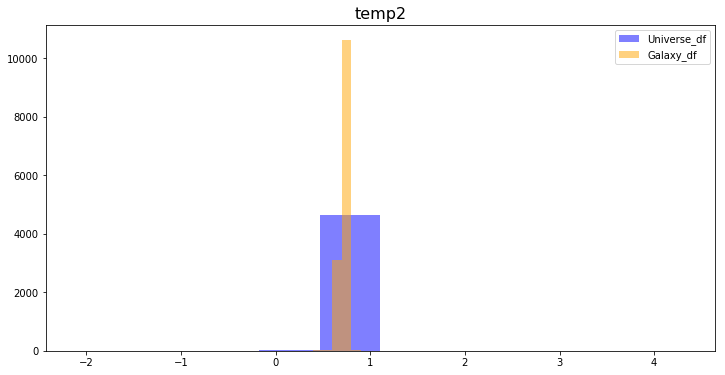

In [46]:
feats = list(galaxy_df.columns[:8]) + list(galaxy_df.columns[-2:])
for col, i in zip(feats,range(X.shape[1])):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.hist(X[:,i], color='blue', alpha = 0.5, label = 'Universe_df')
    ax.hist(X_train[:,i], color='orange', alpha=0.5, label='Galaxy_df')
    ax.set_title(col, fontsize=16)
    ax.legend()

<div class="alert alert-block alert-info">

From the above distribution plots, we see that the distributions of most of the features are alike. Some features, however, are not similar. Specifically, the measurements for the colors have different distributions. Most likely, the observations of these variables were collected on some different setting (perhaps a different scale). However, we see that the difference of the colors have more similar distributions in both datasets, implying that the difference in the distribution of the colors is due to some scaling. 

<br/>
<br/>

To address this issue,  we can look to retrain our original model (trained on the 10 features) but exclude the pure measurements of color (only using the differences we calculated). Since these remaining 7 features - ['de_vaucouleurs_fit_axial_ratio', 'exponential_fit_axial_ratio', 'exponential_disc_fit_log_likelihood', 'de_vaucouleurs_fit_log_likelihood', 'star_log_likelihood', 'temp1', 'temp2'] - have similar distributions across dataset, the performance of the model trained on one datset may carry over to the other i.e. one dataset is representative of the other. 

</div>


In [159]:
def build_update(n, k, batch, epoch, init, actv_fun, optm, wait=20):
    '''
    n = number of extra hidden layers after the first
    k = constant determining number of nodes in each layer
    batch = batch size
    epoch = number of epochs
    init = initializer
    actv_fun = activation function
    optm = optimizer
    wait = patience for early stopping 
    '''
    # begin model
    ann = Sequential()
    
    # define input layer and first hidden layer
    ann.add(Dense(k*X_train[:,3:].shape[1], input_shape=(X_train[:,3:].shape[1],),
                  activation=actv_fun, kernel_initializer=init))
    
    # define next n hidden layers
    for i in range(n):
        # add second hidden layer
        ann.add(Dense(k*X_train[:,3:].shape[1], activation=actv_fun, kernel_initializer=init))
 
    # add output layer 
    ann.add(Dense(2, activation='sigmoid', kernel_initializer=init))
    
    # callbacks
    # callbacks = [EarlyStopping(monitor='val_loss', patience=wait)]

    # compile it 
    ann.compile(loss='binary_crossentropy', optimizer=optm, metrics=['acc'])
    
    # fit 
    ann.fit(
        X_train[:,3:], y_train,
        batch_size = batch, epochs=epoch,
        #callbacks=callbacks,
        verbose=False)
    
    return(ann)

5928/5928 [==============================] - 0s 39us/step


[0.490468967258528, 0.761808367071525]

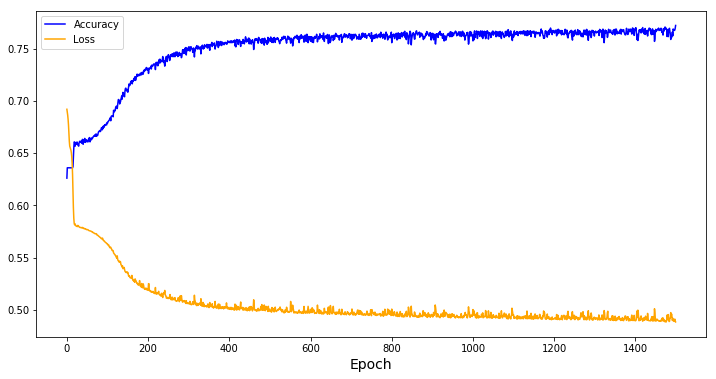

In [167]:
# build on the previous test set, evaluate on previous test set
nn_3 = build_update(n=3,k=2, batch=1024,epoch=1500,init='normal',actv_fun='relu',optm='adam')
plot_nn(nn_3)
nn_3.evaluate(X_test[:,3:], y_test)

In [168]:
# evaluate on the new data in problem 3
nn_3.evaluate(X[:,3:], y)

4702/4702 [==============================] - 0s 39us/step


[0.5335000203244994, 0.7347937047304066]

<div class="alert alert-block alert-info">

From the above, we see that we can go from about a 46% accuracy rate on the new data in Problem 3 to about 74% accuracy rate on this new data when we refit the original model on the features that had the same distribution across the datasets. This is a considerable jump and a rather reasonable estimate when considering the jump between datasets. 
 
<br/> 
<br/> 

Importantly, the new model trained on the 7 similarly distributed features performs similarly on both the test set from the galaxy dataset and the labeled universe set. 

</div>


<span class='sub-q'> 3.3 (Implementation not required) </span>  Based on your observations, propose a method to produce an accurate estimate of the proportion of elliptical galaxies in the new data set, support your proposal with results from data analysis and concepts from data science. 

To produce an accurate estimate of the proportion of elliptical galaxies in the new universe data set, we can compare the distributions of the features in the galaxy dataset and the universe dataset. From there, we can train a model based on the features which have similar distributions across datasets. This model can be built combining the entirety of observations of relevant features from both the galaxy dataset and the labeled universe data. This trained model can then be run on the unlabeled universe dataset. 

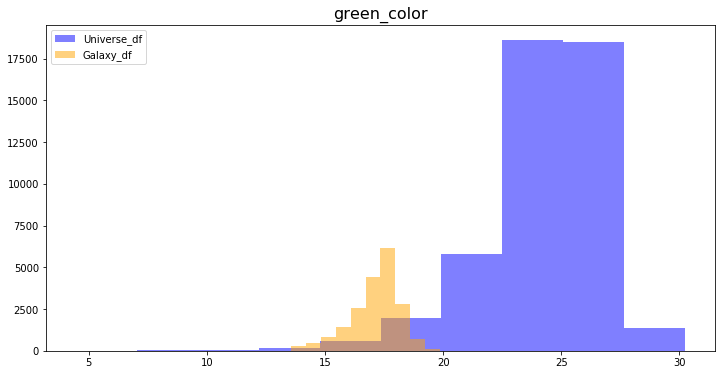

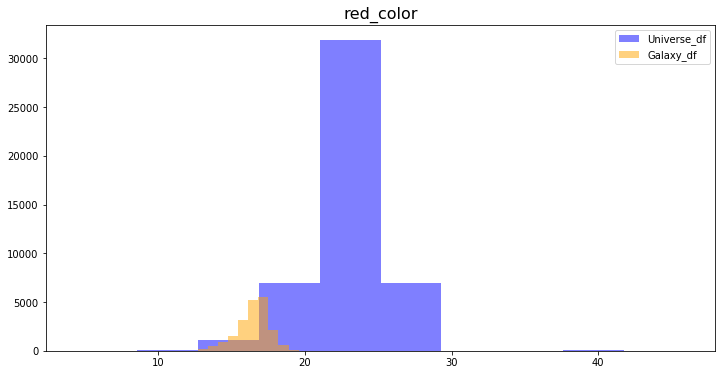

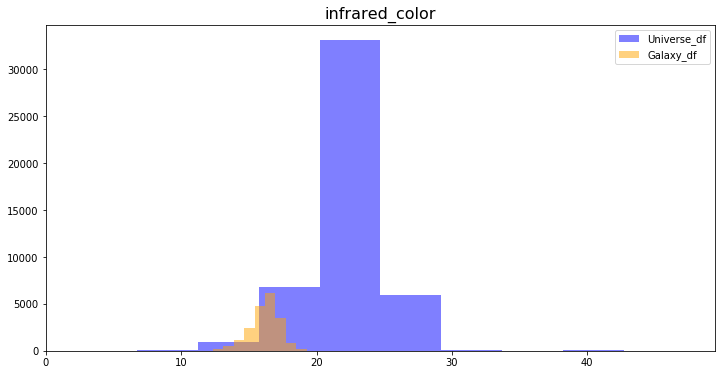

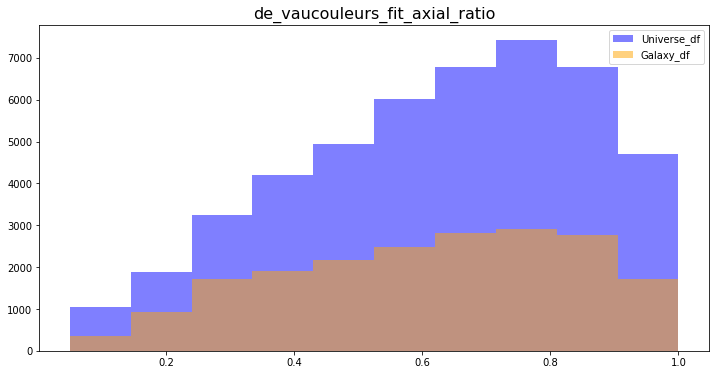

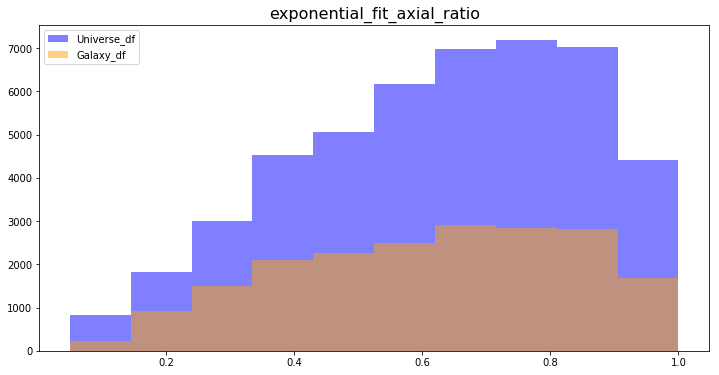

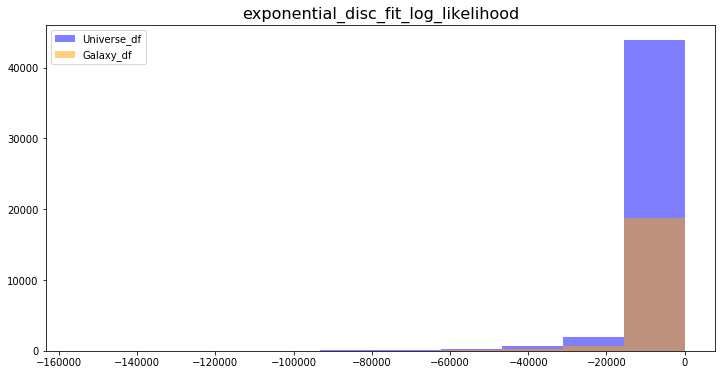

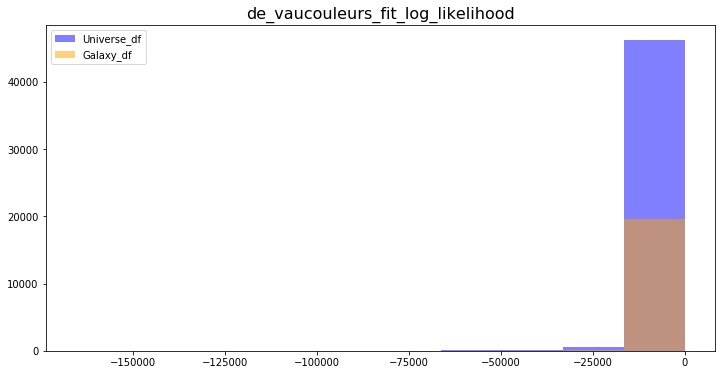

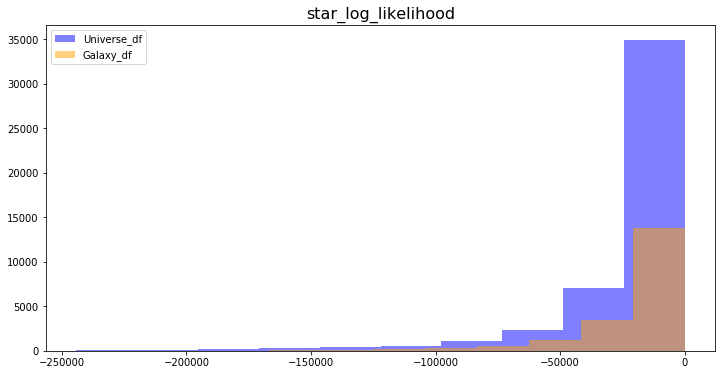

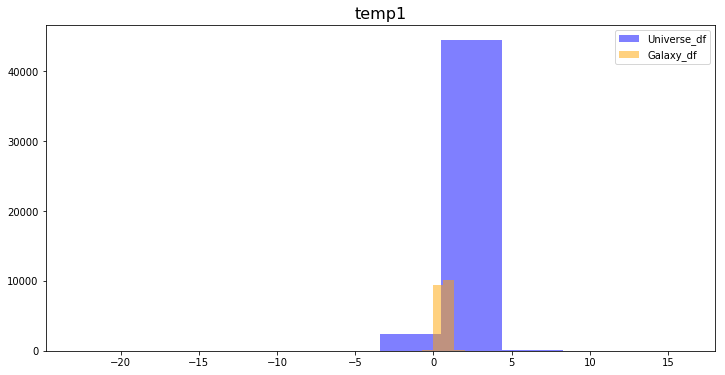

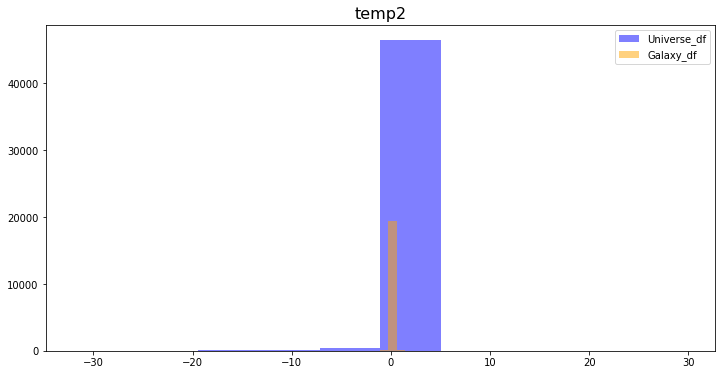

In [57]:
feats = list(galaxy_df.iloc[:, np.r_[0:8, 14:16]].columns)
for col in feats:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.hist(universe_df[col], color='blue', alpha = 0.5, label = 'Universe_df')
    ax.hist(galaxy_df[col], color='orange', alpha=0.5, label='Galaxy_df')
    ax.set_title(col, fontsize=16)
    ax.legend()

<div class="alert alert-block alert-info">

Thus we would build a neural net with the same original architecture from Problem 1 on the features which have similar distributions above across datasets - ['de_vaucouleurs_fit_axial_ratio', 'exponential_fit_axial_ratio', 'exponential_disc_fit_log_likelihood', 'de_vaucouleurs_fit_log_likelihood', 'star_log_likelihood', 'temp1', 'temp2'] - and used that model to predict on the unlabed universe data.


</div>
